# 🧠 Time-Frequency Analysis and Phase Synchrony in Simulated EEG Data

## 1. Simulate Signals with Multiple Frequencies and Noise

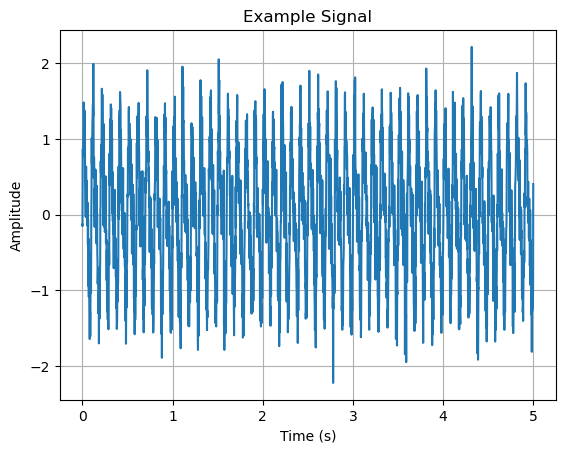

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Simulation parameters
fs = 500  # Sampling frequency  # Sampling frequency in Hz
t = np.arange(0, 2, 1/fs)  # 2 seconds  # Time vector for simulation
n_trials = 100  # Number of trials (simulated repetitions)

# Base signal: mixture of 10Hz and 20Hz with noise
signal = np.array([np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t) + 0.3*np.random.randn(len(t)) for _ in range(n_trials)])  # Number of trials (simulated repetitions)

# Plot one trial
plt.plot(t, signal[0])
plt.title("Example Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


## 2. Frequency-Domain Analysis using FFT

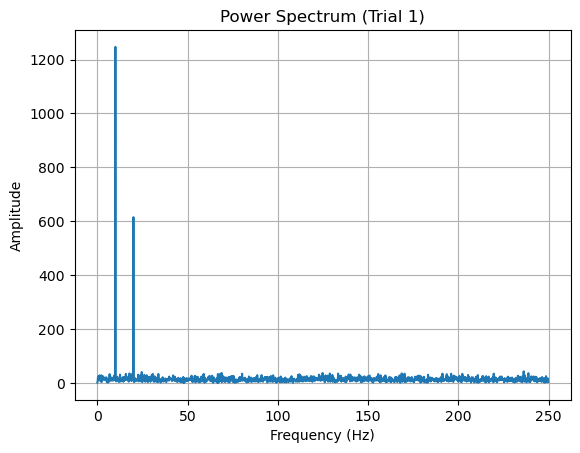

In [42]:
from scipy.fft import fft, fftfreq  # Compute Fast Fourier Transform

fft_vals = fft(signal[0])  # Compute Fast Fourier Transform
freqs = fftfreq(len(t), 1/fs)  # Compute Fast Fourier Transform

plt.plot(freqs[:len(freqs)//2], np.abs(fft_vals[:len(freqs)//2]))  # Compute Fast Fourier Transform
plt.title("Power Spectrum (Trial 1)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


## 3. Time-Frequency Analysis using STFT

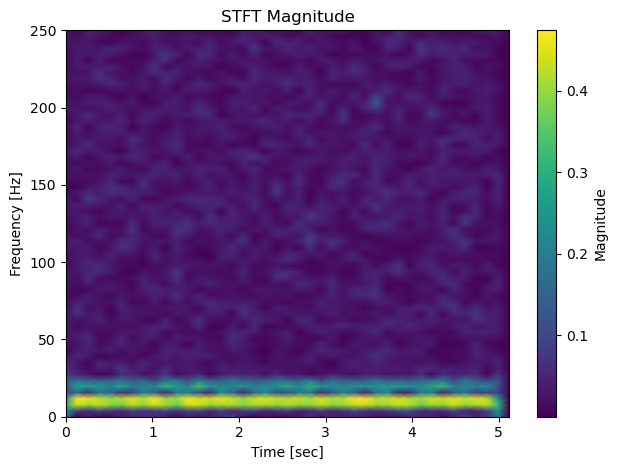

In [43]:
from scipy.signal import stft  # Compute Short-Time Fourier Transform

f, tt, Zxx = stft(signal[0], fs, nperseg=128)  # Compute Short-Time Fourier Transform
plt.pcolormesh(tt, f, np.abs(Zxx), shading='gouraud')  # Plot time-frequency representation
plt.title("STFT Magnitude")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()


## 4. Time-Frequency Analysis using Morlet Wavelet Transform

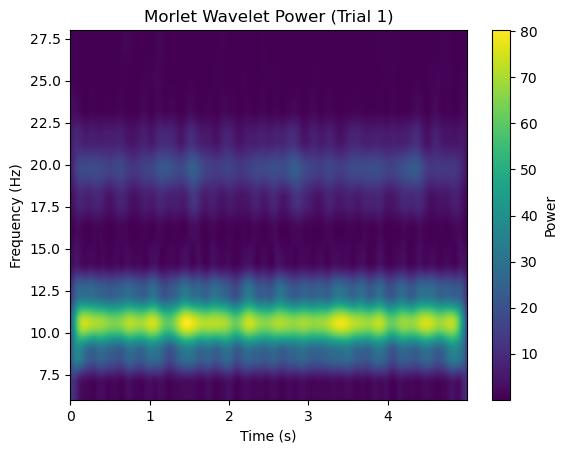

In [ ]:
freqs = np.arange(6, 30, 2)
n_cycles = freqs / 2  # fixed for better resolution

# Compute wavelet power
power = mne.time_frequency.tfr_array_morlet(
    signal[:, np.newaxis, :], sfreq=fs, freqs=freqs,
    n_cycles=n_cycles, output='power', zero_mean=False
)

plt.imshow(power[0, 0, :, :], aspect='auto', origin='lower',
           extent=[t[0], t[-1], freqs[0], freqs[-1]])  # Plot Morlet wavelet power
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Morlet Wavelet Power (Trial 1)")  # Compute Morlet wavelet power using MNE
plt.colorbar(label='Power')
plt.show()


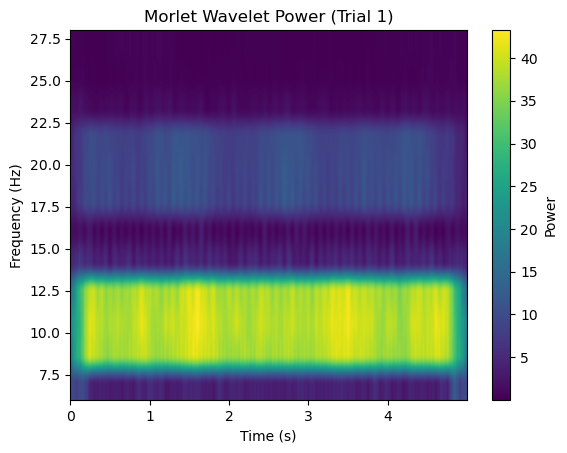

In [49]:
power = mne.time_frequency.tfr_array_multitaper(signal[:, np.newaxis, :], sfreq=fs, freqs=freqs,  # Compute Morlet wavelet power using MNE
                                            n_cycles=n_cycles, output='power', zero_mean=True)

plt.imshow(power[0, 0, :, :], aspect='auto', origin='lower',
           extent=[t[0], t[-1], freqs[0], freqs[-1]])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Morlet Wavelet Power (Trial 1)")  # Compute Morlet wavelet power using MNE
plt.colorbar(label='Power')
plt.show()

## 5. Hilbert Transform for Instantaneous Amplitude & Phase

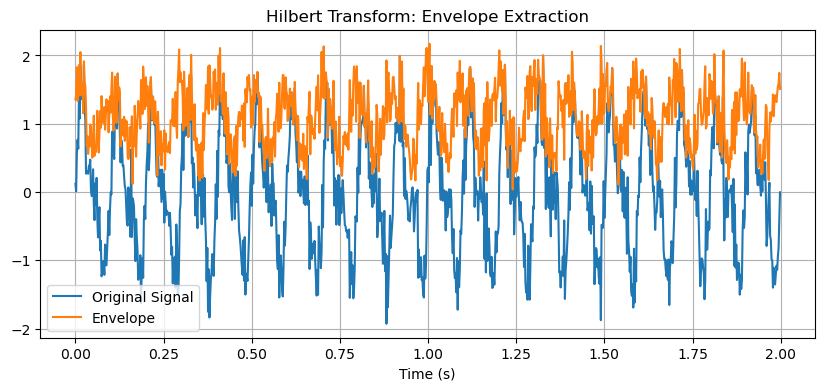

In [7]:
from scipy.signal import hilbert  # Apply Hilbert transform

analytic_signal = hilbert(signal[0])  # Apply Hilbert transform
amplitude_envelope = np.abs(analytic_signal)  # Extract instantaneous amplitude
instantaneous_phase = np.angle(analytic_signal)  # Extract instantaneous phase

plt.figure(figsize=(10, 4))
plt.plot(t, signal[0], label='Original Signal')
plt.plot(t, amplitude_envelope, label='Envelope')  # Extract instantaneous amplitude
plt.title("Hilbert Transform: Envelope Extraction")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()


## 6. Phase Locking Value (PLV)

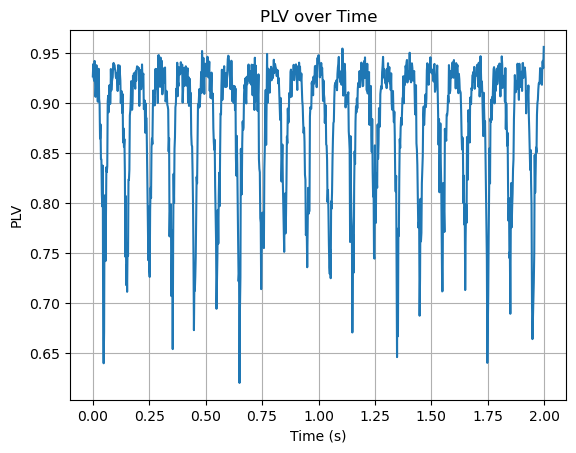

In [8]:
def compute_phase(data):  # Define helper function to extract phase using Hilbert
    return np.angle(hilbert(data, axis=1))  # Apply Hilbert transform

# Simulate second signal with fixed phase offset
phi_diff = np.pi / 4
signal2 = np.array([np.sin(2*np.pi*10*t + phi_diff) + 0.3*np.random.randn(len(t)) for _ in range(n_trials)])  # Number of trials (simulated repetitions)

phase1 = compute_phase(signal)  # Define helper function to extract phase using Hilbert
phase2 = compute_phase(signal2)  # Define helper function to extract phase using Hilbert
phase_diff = phase1 - phase2
plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))  # Compute PLV from phase difference

plt.plot(t, plv)
plt.title("PLV over Time")
plt.xlabel("Time (s)")
plt.ylabel("PLV")
plt.grid(True)
plt.show()


## 7. Surrogate Data Testing for PLV

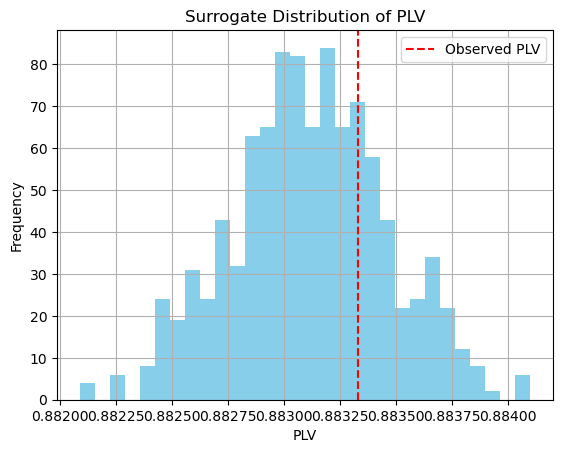

P-value: 0.2600


In [9]:
n_surrogates = 1000
plv_surrogates = []

for _ in range(n_surrogates):
    shift = np.random.randint(len(t))
    shuffled = np.roll(phase2, shift, axis=1)  # Create surrogate data by circular phase shifting
    diff = phase1 - shuffled
    surrogate_plv = np.abs(np.mean(np.exp(1j * diff), axis=0))
    plv_surrogates.append(np.mean(surrogate_plv))

plv_surrogates = np.array(plv_surrogates)
mean_plv_obs = np.mean(plv)

plt.hist(plv_surrogates, bins=30, color='skyblue')  # Plot histogram of surrogate PLVs
plt.axvline(mean_plv_obs, color='red', linestyle='--', label='Observed PLV')
plt.title("Surrogate Distribution of PLV")
plt.xlabel("PLV")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

p_val = np.mean(plv_surrogates >= mean_plv_obs)  # Calculate p-value based on surrogate distribution
print(f"P-value: {p_val:.4f}")  # Calculate p-value based on surrogate distribution
